# Final Team Project: Music Genre and Composer Classification Using Deep Learning

## Introduction
Music is a form of art that is ubiquitous and has a rich history. Different composers have created music with their unique styles and compositions. However, identifying the composer of a particular piece of music can be a challenging task, especially for novice musicians or listeners. The proposed project aims to use deep learning techniques to identify the composer of a given piece of music accurately.

## Objective
The primary objective of this project is to develop a deep learning model that can predict the composer of a given musical score accurately. The project aims to accomplish this objective by using two deep learning techniques: Long Short-Term Memory (LSTM) and Convolutional Neural Network (CNN).

## Dataset
The project will use a dataset consisting of musical scores from various composers.

The dataset contains the midi files of compositions from well-known classical composers like Bach, Beethoven, Chopin, and Mozart. The dataset should be labeled with the name of the composer for each score.

1-Bach  
2-Beethoven  
3-Chopin  
4-Mozart  

## Methodology
The proposed project will be implemented using the following steps:

1. **Data Collection**: Data is collected and provided to you.
2. **Data Pre-processing**: Convert the musical scores into a format suitable for deep learning models. This involves converting the musical scores into MIDI files and applying data augmentation techniques.
3. **Feature Extraction**: Extract features from the MIDI files, such as notes, chords, and tempo, using music analysis tools.
4. **Model Building**: Develop a deep learning model using LSTM and CNN architectures to classify the musical scores according to the composer.
5. **Model Training**: Train the deep learning model using the pre-processed and feature-extracted data.
6. **Model Evaluation**: Evaluate the performance of the deep learning model using accuracy, precision, and recall metrics.
7. **Model Optimization**: Optimize the deep learning model by fine-tuning hyperparameters.

## Deliverables
There are **two** deliverables for this Final Project:

1. **Project Report**: A comprehensive documentation/report that describes the methodology, data pre-processing steps, feature extraction techniques, model architecture, and training process for reproducibility and future reference. Write your technical report in APA 7 style. Please submit the report in PDF format and use the File naming convention DeliverableName-TeamNumber.pdf; for example, **Project_Report-Team1.pdf**
    - Your report should:
        - contain a reference list that includes any external sources, libraries, or frameworks used during the project, including proper citations or acknowledgments.
        - include a concluding section or markdown cell that summarizes the project, highlights key findings, and suggests any potential future improvements or extensions to the work.
2. **Project Notebook**: A Jupyter Notebook file (.ipynb) that contains the entire project code, including data pre-processing, feature extraction, model building, training, evaluation, and any additional analysis or visualizations performed during the project.
    - This deliverable will be exported from a Jupyter Notebook and submitted as a PDF or HTML file.

## Conclusion
The proposed project aims to use deep learning techniques to accurately predict the composer of a given musical score. The project will be implemented using LSTM and CNN architectures and will involve data pre-processing, feature extraction, model building, training, and evaluation. The final model can be used by novice musicians, listeners, and music enthusiasts to identify the composer of a musical piece accurately.

**NOTE**: Team members may not get the same grade on the Final Team Project, depending on each team member's level of contribution.

# Imports and File Reads

In [45]:
# Standard library imports
import os
import csv
import warnings

# Data processing and numerical operations
import pandas as pd
import numpy as np

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt
from prettytable import PrettyTable
%matplotlib inline

# MIDI processing
import pretty_midi as pm
import mido

# Machine learning and preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Deep learning frameworks
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Conv2D, MaxPooling2D, Dense, Flatten, Concatenate

import torch as pt

# Progress bar
from tqdm import tqdm

# Configure plotting
plt.style.use('fivethirtyeight')
sns.set_theme(style='whitegrid', palette='deep')

# Suppress warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [46]:
root_dir = '../aai-511_group1/midiclassics'

In [47]:
# lets gain some insight about the size of all our files
# also, need to know how many files are in each composers directory

def get_size(start_path):
    total_size = 0
    file_count = 0
    for dirpath, dirnames, filenames in os.walk(start_path):
        for f in filenames:
            if f.lower().endswith('.mid') or f.lower().endswith('.midi'):
                fp = os.path.join(dirpath, f)
                total_size += os.path.getsize(fp)
                file_count += 1
    return total_size, file_count

def human_readable_size(size, decimal_places=2):
    for unit in ['B', 'KB', 'MB', 'GB', 'TB']:
        if size < 1024.0:
            break
        size /= 1024.0
    return f"{size:.{decimal_places}f} {unit}"

total_size, file_count = get_size(root_dir)

print(f"Total number of MIDI files: {file_count}")
print(f"Total size of MIDI files: {human_readable_size(total_size)}")

print("\nBreakdown by composer:")
for composer in os.listdir(root_dir):
    composer_dir = os.path.join(root_dir, composer)
    if os.path.isdir(composer_dir):
        composer_size, composer_file_count = get_size(composer_dir)
        print(f"  {composer}: {human_readable_size(composer_size)} ({composer_file_count} files)")

Total number of MIDI files: 1629
Total size of MIDI files: 40.37 MB

Breakdown by composer:
  Bach: 13.13 MB (1022 files)
  Beethoven: 13.92 MB (218 files)
  Chopin: 2.77 MB (134 files)
  Mozart: 10.54 MB (255 files)


In [48]:
# lets gain some insight into what type of MIDI files we are dealing with.
# having different types should not affect the performance of our model, 
# but it is a good idea to know which types we have and the amount so that if we needed to,
# we could take the appropriate amount for testing/training/validation datasets.

def get_midi_type(file_path):
    try:
        midi_file = mido.MidiFile(file_path)
        return midi_file.type
    except:
        return None

def count_midi_types(directory):
    type_counts = {0: 0, 1: 0, 2: 0, 'unknown': 0}
    
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith('.mid') or file.lower().endswith('.midi'):
                file_path = os.path.join(root, file)
                midi_type = get_midi_type(file_path)
                if midi_type is not None and midi_type in type_counts:
                    type_counts[midi_type] += 1
                else:
                    type_counts['unknown'] += 1
    
    return type_counts

type_counts = count_midi_types(root_dir)

print("MIDI File Type Counts:")
for midi_type, count in type_counts.items():
    print(f"  Type {midi_type}: {count}")

MIDI File Type Counts:
  Type 0: 40
  Type 1: 1587
  Type 2: 0
  Type unknown: 2


Type 0 files contain a single track with all MIDI messages merged. They're simple and ideal for straightforward playback but lack flexibility for editing.
- Single track combining all MIDI messages.
- Simple playback.
- Limited editing capabilities.

Type 1 files have multiple tracks, each with its own MIDI channel data. This format is preferred for complex compositions where individual track editing is needed.
- Multiple tracks, each with separate MIDI channels.
- Flexible for editing and arranging.
- Ideal for complex compositions.

Type 2 files contain multiple sequences, each with its own tracks. They're used for organizing and triggering different musical segments independently but are less common.
- Multiple sequences with separate tracks.
- Useful for segment organization.
- Rarely used.

In [49]:
def find_unknown_midi_files(directory):
    unknown_files = []
    
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith('.mid') or file.lower().endswith('.midi'):
                file_path = os.path.join(root, file)
                try:
                    midi_file = mido.MidiFile(file_path)
                    # If we can open it with mido but couldn't get the type earlier,
                    # it's worth investigating
                    if midi_file.type not in [0, 1, 2]:
                        unknown_files.append(file_path)
                except:
                    unknown_files.append(file_path)
    
    return unknown_files

unknown_files = find_unknown_midi_files(root_dir)

print("Files that couldn't be identified:")
for file in unknown_files:
    print(file)

Files that couldn't be identified:
../aai-511_group1/midiclassics\Beethoven\Anhang 14-3.mid
../aai-511_group1/midiclassics\Mozart\K281 Piano Sonata n03 3mov.mid


Since these files types could not be indentified, I used an online MIDI player to make sure they were not corrupted files and still contained playable music. They are fine, and unsure as to why mido could not identify their type, however this issue should not affect our ability to use these files for our classification task.

# Analysis of single file

In [50]:
single_file = pm.PrettyMIDI('midiclassics/Bach/Minuet in G.mid')

# basic file information
print(f"Time signature changes: {single_file.time_signature_changes}")
print(f"Key signature changes: {single_file.key_signature_changes}")
print(f"Tempo changes: {single_file.get_tempo_changes()}")
print(f"Total duration: {single_file.get_end_time()} seconds")

# instruments
for instrument in single_file.instruments:
    print(f"\nInstrument: {pm.program_to_instrument_name(instrument.program)}")
    print(f"Is drum: {instrument.is_drum}")
    print(f"Number of notes: {len(instrument.notes)}")
    
    # first few notes
    for note in instrument.notes[:5]:
        print(f"  Note: pitch={note.pitch}, start={note.start:.2f}, end={note.end:.2f}, duration={note.end-note.start:.2f}")

# piano roll
piano_roll = single_file.get_piano_roll()
print(f"\nPiano roll shape: {piano_roll.shape}")

Time signature changes: [TimeSignature(numerator=3, denominator=4, time=0.0)]
Key signature changes: [KeySignature(key_number=0, time=0.0)]
Tempo changes: (array([ 0.        , 16.81      , 16.82001268, 16.83003808, 16.83673017,
       16.8467811 , 16.85684482, 16.8669214 , 16.8736477 , 16.88375007,
       16.8938654 , 16.9039937 , 16.91075457, 16.92090892, 16.93107634,
       16.94125687, 16.94805265, 16.9582595 , 16.96847957, 16.9787129 ,
       16.9889595 , 16.99579945, 17.00607272, 17.01635938, 17.02665945,
       17.03353513, 17.04386216, 17.05420271, 17.06455681, 17.07146861,
       17.08184996, 17.09224496, 17.10265368, 17.10960198, 17.12003821,
       17.13048826, 17.14095216, 17.14793734, 17.15842904, 17.16893472,
       17.17945439, 17.18647686, 17.19702463, 17.20758653, 17.22168793,
       17.23227816, 17.24288261, 17.24996176, 17.26059478, 17.27124213,
       17.28190388, 17.28902132, 17.29971194, 17.31041704, 17.32113669,
       17.32829284, 17.33904167, 17.34980517, 17.360

In [51]:
# using Mido for additional information
mid = mido.MidiFile('midiclassics/Bach/Minuet in G.mid')

print(f"Number of tracks: {len(mid.tracks)}")
print(f"MIDI type: {mid.type}")
print(f"Ticks per beat: {mid.ticks_per_beat}")

# analyze the first track
for msg in mid.tracks[0][:10]:
    print(msg)

# all tracks
for i, track in enumerate(mid.tracks):
    print(f"\nTrack {i}: {track.name}")
    for msg in track[:10]:
        print(f"  {msg}")

Number of tracks: 6
MIDI type: 1
Ticks per beat: 120
MetaMessage('track_name', name='Minuet In G', time=0)
MetaMessage('text', text='J.S. Bach', time=0)
MetaMessage('text', text='Sequenced by Michael A. Fenemore\n', time=0)
MetaMessage('text', text='m.a.fenemore@telus.net\n', time=0)
MetaMessage('sequencer_specific', data=(0, 0, 65), time=0)
MetaMessage('time_signature', numerator=3, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0)
MetaMessage('key_signature', key='C', time=0)
MetaMessage('set_tempo', tempo=400000, time=0)
MetaMessage('set_tempo', tempo=400000, time=5039)
MetaMessage('set_tempo', tempo=400507, time=4)

Track 0: Minuet In G
  MetaMessage('track_name', name='Minuet In G', time=0)
  MetaMessage('text', text='J.S. Bach', time=0)
  MetaMessage('text', text='Sequenced by Michael A. Fenemore\n', time=0)
  MetaMessage('text', text='m.a.fenemore@telus.net\n', time=0)
  MetaMessage('sequencer_specific', data=(0, 0, 65), time=0)
  MetaMessage('time_signa

In [52]:
# features = ['note_sequence', 'duration', 'tempo', 'average_velocity', 
#             'max_velocity', 'min_velocity', 'velocity_std', 'pitch_range', 
#             'num_instruments', 'note_density', 'num_notes', 'average_pitch', 
#             'max_pitch', 'min_pitch', 'pitch_std', 'articulations']

def extract_features(midi_file_path):
    prettymidi = pm.PrettyMIDI(midi_file_path)
    mid = mido.MidiFile(midi_file_path)

    # feature dictionary
    features = {}

    # Note sequence (we'll use a simplified representation)
    notes = [note for instrument in prettymidi.instruments for note in instrument.notes]
    notes.sort(key=lambda x: x.start)
    features['note_sequence'] = '-'.join([str(note.pitch) for note in notes[:20]])  # First 20 notes

    # Duration
    features['duration'] = prettymidi.get_end_time()

    # Tempo (average tempo)
    tempos = [msg.tempo for msg in mid.tracks[0] if msg.type == 'set_tempo']
    features['tempo'] = sum(tempos) / len(tempos) if tempos else 0

    # Velocity statistics
    velocities = [note.velocity for note in notes]
    features['average_velocity'] = np.mean(velocities)
    features['max_velocity'] = np.max(velocities)
    features['min_velocity'] = np.min(velocities)
    features['velocity_std'] = np.std(velocities)

    # Pitch statistics
    pitches = [note.pitch for note in notes]
    features['pitch_range'] = np.max(pitches) - np.min(pitches)
    features['average_pitch'] = np.mean(pitches)
    features['max_pitch'] = np.max(pitches)
    features['min_pitch'] = np.min(pitches)
    features['pitch_std'] = np.std(pitches)

    # Number of instruments
    features['num_instruments'] = len(prettymidi.instruments)

    # Note density (notes per second)
    features['note_density'] = len(notes) / features['duration']

    # Number of notes
    features['num_notes'] = len(notes)

    # Articulations (simplified as average note duration)
    note_durations = [note.end - note.start for note in notes]
    features['articulations'] = np.mean(note_durations)

    return features

def create_features_dataframe(midi_file_paths):
    all_features = []
    for file_path in midi_file_paths:
        features = extract_features(file_path)
        all_features.append(features)
    return pd.DataFrame(all_features)

midi_files = ['midiclassics/Bach/Minuet in G.mid']
df = create_features_dataframe(midi_files)
print(df.info())
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   note_sequence     1 non-null      object 
 1   duration          1 non-null      float64
 2   tempo             1 non-null      float64
 3   average_velocity  1 non-null      float64
 4   max_velocity      1 non-null      int32  
 5   min_velocity      1 non-null      int32  
 6   velocity_std      1 non-null      float64
 7   pitch_range       1 non-null      int32  
 8   average_pitch     1 non-null      float64
 9   max_pitch         1 non-null      int32  
 10  min_pitch         1 non-null      int32  
 11  pitch_std         1 non-null      float64
 12  num_instruments   1 non-null      int64  
 13  note_density      1 non-null      float64
 14  num_notes         1 non-null      int64  
 15  articulations     1 non-null      float64
dtypes: float64(8), int32(5), int64(2), object(1)
mem

,duration,tempo,average_velocity,max_velocity,min_velocity,velocity_std,pitch_range,average_pitch,max_pitch,min_pitch,pitch_std,num_instruments,note_density,num_notes,articulations
count,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.000000,1.0,1.0,1.000000,1.0,1.000000,1.0,1.000000
mean,42.109281,507288.281573,121.280193,127.0,111.0,7.668163,40.0,66.086957,83.0,43.0,8.452892,2.0,4.915781,207.0,0.405489
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,42.109281,507288.281573,121.280193,127.0,111.0,7.668163,40.0,66.086957,83.0,43.0,8.452892,2.0,4.915781,207.0,0.405489
25%,42.109281,507288.281573,121.280193,127.0,111.0,7.668163,40.0,66.086957,83.0,43.0,8.452892,2.0,4.915781,207.0,0.405489
50%,42.109281,507288.281573,121.280193,127.0,111.0,7.668163,40.0,66.086957,83.0,43.0,8.452892,2.0,4.915781,207.0,0.405489
75%,42.109281,507288.281573,121.280193,127.0,111.0,7.668163,40.0,66.086957,83.0,43.0,8.452892,2.0,4.915781,207.0,0.405489
max,42.109281,507288.281573,121.280193,127.0,111.0,7.668163,40.0,66.086957,83.0,43.0,8.452892,2.0,4.915781,207.0,0.405489


In [53]:
def extract_features(midi_file_path, sequence_length=5000):
    prettymidi = pm.PrettyMIDI(midi_file_path)
    
    # Basic features
    duration = prettymidi.get_end_time()
    num_instruments = len(prettymidi.instruments)
    
    # Note sequence matrix
    notes = [note for instrument in prettymidi.instruments for note in instrument.notes]
    notes.sort(key=lambda x: x.start)
    note_seq_matrix = np.array([[note.start, note.pitch, note.end - note.start, note.velocity] for note in notes])
    
    # Piano roll matrix
    piano_roll = prettymidi.get_piano_roll(fs=50)  # 50 frames per second
    piano_roll = piano_roll[:, :sequence_length]  # Trim or pad to sequence_length
    if piano_roll.shape[1] < sequence_length:
        piano_roll = np.pad(piano_roll, ((0, 0), (0, sequence_length - piano_roll.shape[1])))
    
    # Chroma matrix
    chroma = prettymidi.get_chroma(fs=50)
    chroma = chroma[:, :sequence_length]
    if chroma.shape[1] < sequence_length:
        chroma = np.pad(chroma, ((0, 0), (0, sequence_length - chroma.shape[1])))
    
    # Onset matrix
    onset = np.zeros_like(piano_roll)
    for instrument in prettymidi.instruments:
        for note in instrument.notes:
            start_idx = int(note.start * 50)
            if start_idx < sequence_length:
                onset[note.pitch, start_idx] = note.velocity
    
    # Rhythm matrix
    rhythm = np.sum(onset, axis=0, keepdims=True)
    rhythm = (rhythm > 0).astype(int)
    
    return {
        'duration': duration,
        'num_instruments': num_instruments,
        'note_sequence': note_seq_matrix,
        'piano_roll': piano_roll,
        'chroma': chroma,
        'onset': onset,
        'rhythm': rhythm
    }

def create_features_dataframe(midi_file_paths):
    all_features = []
    for file_path in midi_file_paths:
        features = extract_features(file_path)
        all_features.append(features)
    
    # Convert to DataFrame
    df = pd.DataFrame(all_features)
    return df

midi_files = ['midiclassics/Bach/Minuet in G.mid']
df = create_features_dataframe(midi_files)
df.info()
display(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   duration         1 non-null      float64
 1   num_instruments  1 non-null      int64  
 2   note_sequence    1 non-null      object 
 3   piano_roll       1 non-null      object 
 4   chroma           1 non-null      object 
 5   onset            1 non-null      object 
 6   rhythm           1 non-null      object 
dtypes: float64(1), int64(1), object(5)
memory usage: 184.0+ bytes


,duration,num_instruments
count,1.000000,1.0
mean,42.109281,2.0
std,NaN,NaN
min,42.109281,2.0
25%,42.109281,2.0
50%,42.109281,2.0
75%,42.109281,2.0
max,42.109281,2.0


+------------+--------------+----------+----------+
| Start Time | Pitch (Note) | Duration | Velocity |
+------------+--------------+----------+----------+
|    0.00    |     74.0     |   0.40   |  127.0   |
|    0.00    |     55.0     |   0.80   |  111.0   |
|    0.00    |     62.0     |   0.80   |  111.0   |
|    0.00    |     59.0     |   0.80   |  111.0   |
|    0.40    |     67.0     |   0.20   |  127.0   |
|    0.60    |     69.0     |   0.20   |  127.0   |
|    0.79    |     57.0     |   0.40   |  111.0   |
|    0.80    |     71.0     |   0.20   |  127.0   |
|    1.00    |     72.0     |   0.20   |  127.0   |
|    1.19    |     59.0     |   1.20   |  111.0   |
|    1.20    |     74.0     |   0.40   |  127.0   |
|    1.60    |     67.0     |   0.20   |  127.0   |
|    2.00    |     67.0     |   0.40   |  127.0   |
|    2.39    |     60.0     |   1.20   |  111.0   |
|    2.40    |     76.0     |   0.40   |  127.0   |
|    2.80    |     72.0     |   0.20   |  127.0   |
|    3.00   

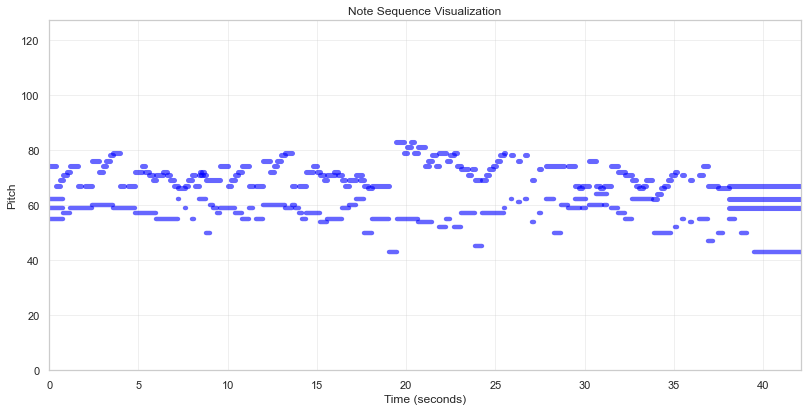

In [54]:
def print_note_sequence(note_sequence, num_notes=20):
    table = PrettyTable()
    table.field_names = ["Start Time", "Pitch (Note)", "Duration", "Velocity"]
    table.align["Start Time"] = "c"
    table.align["Pitch (Note)"] = "c"
    table.align["Duration"] = "c"
    table.align["Velocity"] = "c"
    
    for note in note_sequence[:num_notes]:
        table.add_row([
            f"{note[0]:.2f}",
            f"{note[1]:.1f}",
            f"{note[2]:.2f}",
            f"{note[3]:.1f}"
        ])
    
    print(table)
    
    if len(note_sequence) > num_notes:
        print(f"... (showing {num_notes} out of {len(note_sequence)} notes)")

# After creating the DataFrame
note_sequence = df['note_sequence'][0]  # Get the note sequence for the first file
print_note_sequence(note_sequence)

def plot_note_sequence(note_sequence, max_time=None):
    if max_time is None:
        max_time = note_sequence[-1, 0] + note_sequence[-1, 2]  # Last note end time
    
    plt.figure(figsize=(12, 6))
    for note in note_sequence:
        start_time, pitch, duration, velocity = note
        plt.plot([start_time, start_time + duration], [pitch, pitch], 
                 linewidth=velocity/25, color='blue', alpha=0.6)
    
    plt.xlabel('Time (seconds)')
    plt.ylabel('Pitch')
    plt.title('Note Sequence Visualization')
    plt.ylim(0, 127)
    plt.xlim(0, max_time)
    plt.grid(True, alpha=0.3)
    plt.show()

note_sequence = df['note_sequence'][0]
plot_note_sequence(note_sequence)

Ignore the cells beyond this for now.

In [55]:
def analyze_midi_file(file_path):
    midi_data = pm.PrettyMIDI(file_path)
    
    info = {
        'filename': file_path.split('/')[-1],
        'total_duration': midi_data.get_end_time(),
        'tempo': midi_data.estimate_tempo(),
        'time_signature_changes': len(midi_data.time_signature_changes),
        'key_signature_changes': len(midi_data.key_signature_changes),
        'number_of_instruments': len(midi_data.instruments),
    }
    
    all_notes = []
    all_control_changes = []
    all_pitch_bends = []
    
    for i, instrument in enumerate(midi_data.instruments):
        info[f'instrument_{i}_name'] = instrument.name
        info[f'instrument_{i}_program'] = instrument.program
        info[f'instrument_{i}_is_drum'] = instrument.is_drum
        info[f'instrument_{i}_note_count'] = len(instrument.notes)
        
        for note in instrument.notes:
            all_notes.append({
                'track': i,
                'type': 'note',
                'start': note.start,
                'end': note.end,
                'pitch': note.pitch,
                'velocity': note.velocity
            })
        
        for cc in instrument.control_changes:
            all_control_changes.append({
                'track': i,
                'type': 'control_change',
                'start': cc.time,
                'number': cc.number,
                'value': cc.value
            })
        
        for pb in instrument.pitch_bends:
            all_pitch_bends.append({
                'track': i,
                'type': 'pitch_bend',
                'start': pb.time,
                'value': pb.pitch
            })
    
    # Tempo changes
    tempo_times, tempo_values = midi_data.get_tempo_changes()
    tempo_changes = [{
        'type': 'tempo_change',
        'start': tempo_times[i],
        'tempo': tempo_values[i]
    } for i in range(len(tempo_times))]
    
    return info, all_notes, all_control_changes, all_pitch_bends, tempo_changes

file_path = '../aai-511_group1/midiclassics/Bach/AveMaria.mid'
info, notes, control_changes, pitch_bends, tempo_changes = analyze_midi_file(file_path)


df_info = pd.DataFrame([info])
df_notes = pd.DataFrame(notes)
df_control_changes = pd.DataFrame(control_changes)
df_pitch_bends = pd.DataFrame(pitch_bends)
df_tempo_changes = pd.DataFrame(tempo_changes)

display(df_info.info())
display(df_notes.info())
display(df_control_changes.info())
display(df_pitch_bends.info())
display(df_tempo_changes.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   filename                 1 non-null      object 
 1   total_duration           1 non-null      float64
 2   tempo                    1 non-null      float64
 3   time_signature_changes   1 non-null      int64  
 4   key_signature_changes    1 non-null      int64  
 5   number_of_instruments    1 non-null      int64  
 6   instrument_0_name        1 non-null      object 
 7   instrument_0_program     1 non-null      int32  
 8   instrument_0_is_drum     1 non-null      bool   
 9   instrument_0_note_count  1 non-null      int64  
 10  instrument_1_name        1 non-null      object 
 11  instrument_1_program     1 non-null      int32  
 12  instrument_1_is_drum     1 non-null      bool   
 13  instrument_1_note_count  1 non-null      int64  
 14  instrument_2_name        1 non

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 793 entries, 0 to 792
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   track     793 non-null    int64  
 1   type      793 non-null    object 
 2   start     793 non-null    float64
 3   end       793 non-null    float64
 4   pitch     793 non-null    int64  
 5   velocity  793 non-null    int64  
dtypes: float64(2), int64(3), object(1)
memory usage: 37.3+ KB


None

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Empty DataFrame


None

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Empty DataFrame


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   type    1 non-null      object 
 1   start   1 non-null      float64
 2   tempo   1 non-null      float64
dtypes: float64(2), object(1)
memory usage: 152.0+ bytes


None

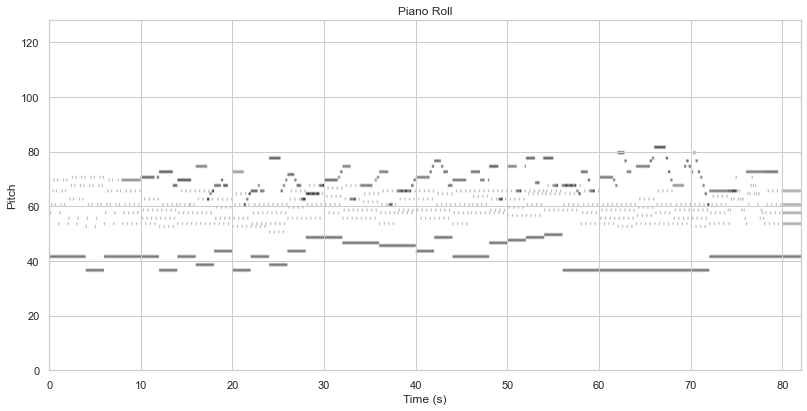

In [56]:
def plot_piano_roll(pm, start_time=0, end_time=None, fs=100):
    """
    Plot a piano roll for the given pretty_midi object.

    Parameters:
    - pm: pretty_midi.PrettyMIDI object
    - start_time: float, start time in seconds
    - end_time: float, end time in seconds
    - fs: int, frame rate of the piano roll (frames per second)
    """
    if end_time is None:
        end_time = pm.get_end_time()
    
    # Get the piano roll (notes)
    piano_roll = pm.get_piano_roll(fs=fs)
    
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot the piano roll
    ax.imshow(piano_roll, aspect='auto', origin='lower', 
              extent=[start_time, end_time, 0, 128], cmap='gray_r')
    
    # Set the labels and title
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Pitch')
    ax.set_title('Piano Roll')
    
    plt.show()


midi_data = pm.PrettyMIDI(file_path)
plot_piano_roll(midi_data)

In [57]:
# def process_midi_directory(root_dir):
#     data = []
#     for composer in os.listdir(root_dir):
#         composer_dir = os.path.join(root_dir, composer)
#         if os.path.isdir(composer_dir):
#             for root, _, files in os.walk(composer_dir):
#                 for file in tqdm(files, desc=f"Processing {composer}"):
#                     if file.lower().endswith(('.mid', '.midi')):
#                         file_path = os.path.join(root, file)
#                         try:
#                             info, notes, control_changes, pitch_bends, tempo_changes = analyze_midi_file(file_path)
#                             info['composer'] = composer
#                             data.append(info)
#                         except Exception as e:
#                             print(f"Error processing {file_path}: {str(e)}")
    
#     return pd.DataFrame(data)


# midi_dataset = process_midi_directory(root_dir)
# midi_dataset.to_csv('midi_dataset.csv', index=False, escapechar='\\', quoting=csv.QUOTE_ALL)

# display(midi_dataset.head())
# display(midi_dataset.shape)

In [58]:
def process_midi_directory(root_dir):
    data = []
    all_notes = []
    all_control_changes = []
    all_pitch_bends = []
    all_tempo_changes = []
    
    for composer in os.listdir(root_dir):
        composer_dir = os.path.join(root_dir, composer)
        if os.path.isdir(composer_dir):
            for root, _, files in os.walk(composer_dir):
                for file in tqdm(files, desc=f"Processing {composer}"):
                    if file.lower().endswith(('.mid', '.midi')):
                        file_path = os.path.join(root, file)
                        try:
                            info, notes, control_changes, pitch_bends, tempo_changes = analyze_midi_file(file_path)
                            info['composer'] = composer
                            data.append(info)
                            
                            file_id = len(data) - 1  # Use this as a unique identifier for the file
                            
                            for note in notes:
                                note['file_id'] = file_id
                                all_notes.append(note)
                            
                            for cc in control_changes:
                                cc['file_id'] = file_id
                                all_control_changes.append(cc)
                            
                            for pb in pitch_bends:
                                pb['file_id'] = file_id
                                all_pitch_bends.append(pb)
                            
                            for tc in tempo_changes:
                                tc['file_id'] = file_id
                                all_tempo_changes.append(tc)
                            
                        except Exception as e:
                            print(f"Error processing {file_path}: {str(e)}")
    
    df_info = pd.DataFrame(data)
    df_notes = pd.DataFrame(all_notes)
    df_control_changes = pd.DataFrame(all_control_changes)
    df_pitch_bends = pd.DataFrame(all_pitch_bends)
    df_tempo_changes = pd.DataFrame(all_tempo_changes)
    
    return df_info, df_notes, df_control_changes, df_pitch_bends, df_tempo_changes


df_info, df_notes, df_control_changes, df_pitch_bends, df_tempo_changes = process_midi_directory(root_dir)

df_info.to_csv('midi_info.csv', index=False, escapechar='\\', quoting=csv.QUOTE_ALL)
df_notes.to_csv('midi_notes.csv', index=False, escapechar='\\', quoting=csv.QUOTE_ALL)
df_control_changes.to_csv('midi_control_changes.csv', index=False, escapechar='\\', quoting=csv.QUOTE_ALL)
df_pitch_bends.to_csv('midi_pitch_bends.csv', index=False, escapechar='\\', quoting=csv.QUOTE_ALL)
df_tempo_changes.to_csv('midi_tempo_changes.csv', index=False, escapechar='\\', quoting=csv.QUOTE_ALL)

display(df_info.head())
display(df_info.shape)

Processing Beethoven:   5%|▌         | 11/218 [00:03<00:29,  7.12it/s]

Error processing ../aai-511_group1/midiclassics\Beethoven\Anhang 14-3.mid: Could not decode key with 3 flats and mode 255


Processing Mozart:  18%|█▊        | 47/255 [00:04<00:30,  6.80it/s]

Error processing ../aai-511_group1/midiclassics\Mozart\K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2


Processing Mozart: 100%|██████████| 255/255 [00:59<00:00,  4.27it/s]


,filename,total_duration,tempo,time_signature_changes,key_signature_changes,number_of_instruments,instrument_0_name,instrument_0_program,instrument_0_is_drum,instrument_0_note_count,...,instrument_37_is_drum,instrument_37_note_count,instrument_38_name,instrument_38_program,instrument_38_is_drum,instrument_38_note_count,instrument_39_name,instrument_39_program,instrument_39_is_drum,instrument_39_note_count
0,midiclassics\Bach\003706b_.mid,46.956456,184.000258,1,1,4,Instrument 1,0,False,70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,midiclassics\Bach\003806b_.mid,45.000000,109.714286,1,1,4,Instrument 1,0,False,61,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,midiclassics\Bach\003907bv.mid,42.500000,140.800000,1,1,4,Instrument 1,0,False,63,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,midiclassics\Bach\003907b_.mid,42.500000,140.800000,1,1,4,Instrument 1,0,False,63,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,midiclassics\Bach\004003b_.mid,30.000000,147.692308,1,1,4,Instrument 1,0,False,43,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(1627, 167)

In [59]:
# Add file_id to df_info
df_info['file_id'] = df_info.index

# Group notes by file_id and create features
note_features = df_notes.groupby('file_id').agg({
    'pitch': ['mean', 'std', 'min', 'max'],
    'velocity': ['mean', 'std', 'min', 'max'],
    'start': ['min', 'max'],
    'end': ['max']
}).reset_index()
note_features.columns = ['file_id'] + [f'note_{col[0]}_{col[1]}' for col in note_features.columns[1:]]

# Create features from control changes
cc_features = df_control_changes.groupby('file_id').agg({
    'number': ['nunique'],
    'value': ['mean', 'std']
}).reset_index()
cc_features.columns = ['file_id'] + [f'cc_{col[0]}_{col[1]}' for col in cc_features.columns[1:]]

# Create features from pitch bends
pb_features = df_pitch_bends.groupby('file_id').agg({
    'value': ['mean', 'std', 'min', 'max']
}).reset_index()
pb_features.columns = ['file_id'] + [f'pb_{col[0]}_{col[1]}' for col in pb_features.columns[1:]]

# Create features from tempo changes
tempo_features = df_tempo_changes.groupby('file_id').agg({
    'tempo': ['mean', 'std', 'min', 'max', 'count']
}).reset_index()
tempo_features.columns = ['file_id'] + [f'tempo_{col[0]}_{col[1]}' for col in tempo_features.columns[1:]]

# Merge all features
combined_features = df_info.merge(note_features, on='file_id', how='left')\
                           .merge(cc_features, on='file_id', how='left')\
                           .merge(pb_features, on='file_id', how='left')\
                           .merge(tempo_features, on='file_id', how='left')

# Fill NaN values (in case some files don't have certain features)
combined_features = combined_features.fillna(0)

print(combined_features.head())
print(combined_features.shape)

# Save the combined_features DataFrame to a CSV file
combined_features.to_csv('combined_features.csv', index=False, escapechar='\\', quoting=csv.QUOTE_ALL)

# Print confirmation
print("DataFrame saved to 'combined_features.csv'")

                         filename  total_duration       tempo  \
0  midiclassics\Bach\003706b_.mid       46.956456  184.000258   
1  midiclassics\Bach\003806b_.mid       45.000000  109.714286   
2  midiclassics\Bach\003907bv.mid       42.500000  140.800000   
3  midiclassics\Bach\003907b_.mid       42.500000  140.800000   
4  midiclassics\Bach\004003b_.mid       30.000000  147.692308   

   time_signature_changes  key_signature_changes  number_of_instruments  \
0                       1                      1                      4   
1                       1                      1                      4   
2                       1                      1                      4   
3                       1                      1                      4   
4                       1                      1                      4   

  instrument_0_name  instrument_0_program  instrument_0_is_drum  \
0      Instrument 1                     0                 False   
1      Instrument 1     

In [60]:
def create_sequence(file_id, max_length=500):
    file_notes = df_notes[df_notes['file_id'] == file_id].sort_values('start')
    sequence = file_notes[['pitch', 'velocity', 'start', 'end']].values
    if len(sequence) > max_length:
        sequence = sequence[:max_length]
    else:
        padding = np.zeros((max_length - len(sequence), 4))
        sequence = np.vstack((sequence, padding))
    return sequence

# Create sequences for each file
X_lstm = np.array([create_sequence(file_id) for file_id in combined_features['file_id']])
y = combined_features['composer'].values

In [61]:
def create_piano_roll(file_id, time_steps=500, pitch_range=128):
    file_notes = df_notes[df_notes['file_id'] == file_id]
    piano_roll = np.zeros((time_steps, pitch_range))
    for _, note in file_notes.iterrows():
        start = int(note['start'] * time_steps / file_notes['end'].max())
        end = int(note['end'] * time_steps / file_notes['end'].max())
        pitch = int(note['pitch'])
        piano_roll[start:end, pitch] = note['velocity']
    return piano_roll

# Create piano rolls for each file
X_cnn = np.array([create_piano_roll(file_id) for file_id in combined_features['file_id']])

In [62]:
# Normalize LSTM input
scaler_lstm = StandardScaler()
X_lstm_scaled = scaler_lstm.fit_transform(X_lstm.reshape(-1, X_lstm.shape[-1])).reshape(X_lstm.shape)

# Normalize CNN input (assuming X_cnn is already created)
scaler_cnn = StandardScaler()
X_cnn_scaled = scaler_cnn.fit_transform(X_cnn.reshape(-1, X_cnn.shape[-1])).reshape(X_cnn.shape)

# Normalize combined features
X_combined = combined_features.select_dtypes(include=[np.number])
scaler_combined = StandardScaler()
X_combined_scaled = scaler_combined.fit_transform(X_combined)

In [63]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("X_lstm_scaled shape:", X_lstm_scaled.shape)
print("X_cnn_scaled shape:", X_cnn_scaled.shape)
print("X_combined_scaled shape:", X_combined_scaled.shape)
print("y_encoded shape:", y_encoded.shape)

X_lstm_scaled shape: (1627, 500, 4)
X_cnn_scaled shape: (1627, 500, 128)
X_combined_scaled shape: (1627, 109)
y_encoded shape: (1627,)


In [64]:
X_lstm_train, X_lstm_test, X_cnn_train, X_cnn_test, X_combined_train, X_combined_test, y_train, y_test = train_test_split(
    X_lstm_scaled, X_cnn_scaled, X_combined_scaled, y_encoded, test_size=0.2, random_state=42
)

print("After splitting:")
print("X_lstm_train shape:", X_lstm_train.shape)
print("X_cnn_train shape:", X_cnn_train.shape)
print("X_combined_train shape:", X_combined_train.shape)
print("y_train shape:", y_train.shape)

After splitting:
X_lstm_train shape: (1301, 500, 4)
X_cnn_train shape: (1301, 500, 128)
X_combined_train shape: (1301, 109)
y_train shape: (1301,)


In [65]:
# LSTM input
lstm_input = Input(shape=(X_lstm_train.shape[1], X_lstm_train.shape[2]))
lstm_out = LSTM(64)(lstm_input)

# CNN input
cnn_input = Input(shape=(X_cnn_train.shape[1], X_cnn_train.shape[2], 1))
conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(cnn_input)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
flatten = Flatten()(pool1)

# Combined features input
combined_input = Input(shape=(X_combined_train.shape[1],))

# Merge all features
merged = Concatenate()([lstm_out, flatten, combined_input])

# Output layer
output = Dense(len(np.unique(y)), activation='softmax')(merged)

# Create model
model = Model(inputs=[lstm_input, cnn_input, combined_input], outputs=output)

# Compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
history = model.fit(
    [X_lstm_train, X_cnn_train, X_combined_train], 
    y_train, 
    validation_split=0.2, 
    epochs=50, 
    batch_size=32
)

Epoch 1/50
33/33 [==============================] - 19s 504ms/step - loss: 5.0666 - accuracy: 0.6663 - val_loss: 2.0761 - val_accuracy: 0.7739
Epoch 2/50
33/33 [==============================] - 17s 506ms/step - loss: 0.4707 - accuracy: 0.9029 - val_loss: 1.8333 - val_accuracy: 0.7854
Epoch 3/50
33/33 [==============================] - 15s 462ms/step - loss: 0.0668 - accuracy: 0.9769 - val_loss: 1.7566 - val_accuracy: 0.7816
Epoch 4/50
33/33 [==============================] - 15s 467ms/step - loss: 0.0070 - accuracy: 0.9981 - val_loss: 1.6447 - val_accuracy: 0.7854
Epoch 5/50
33/33 [==============================] - 16s 472ms/step - loss: 0.0046 - accuracy: 0.9990 - val_loss: 1.7800 - val_accuracy: 0.7739
Epoch 6/50
33/33 [==============================] - 15s 469ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 1.7294 - val_accuracy: 0.7778
Epoch 7/50
33/33 [==============================] - 15s 463ms/step - loss: 9.5340e-04 - accuracy: 1.0000 - val_loss: 1.7198 - val_accuracy: 0.

11/11 [==============================] - 1s 127ms/step - loss: 1.5417 - accuracy: 0.8067
Test Loss: 1.5417
Test Accuracy: 0.8067
11/11 [==============================] - 2s 122ms/step


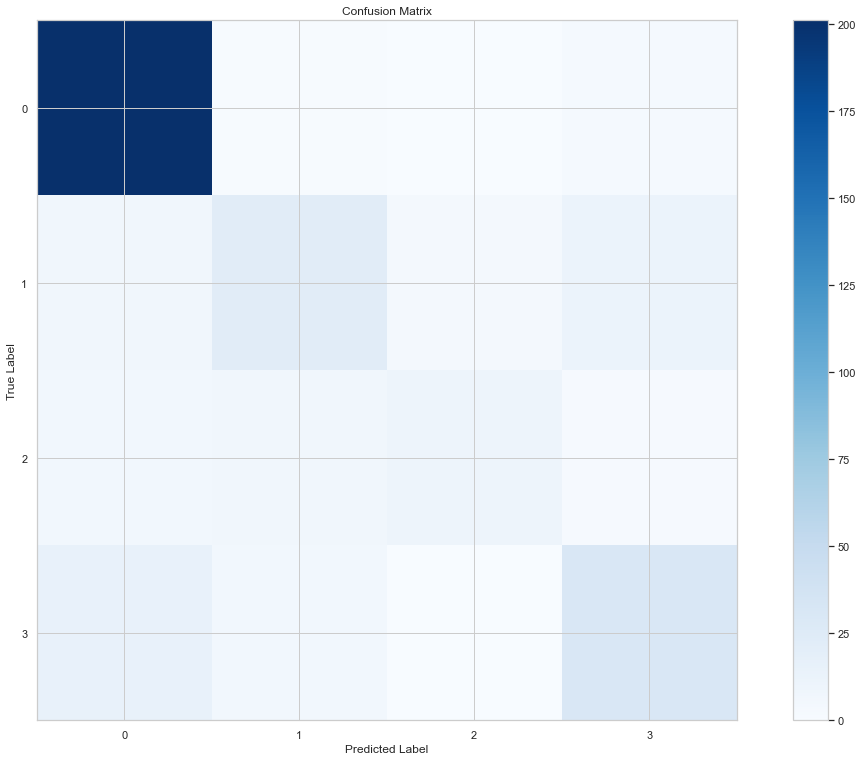

              precision    recall  f1-score   support

           0       0.88      0.98      0.93       205
           1       0.61      0.49      0.54        45
           2       0.71      0.40      0.51        25
           3       0.64      0.59      0.61        51

    accuracy                           0.81       326
   macro avg       0.71      0.61      0.65       326
weighted avg       0.79      0.81      0.79       326



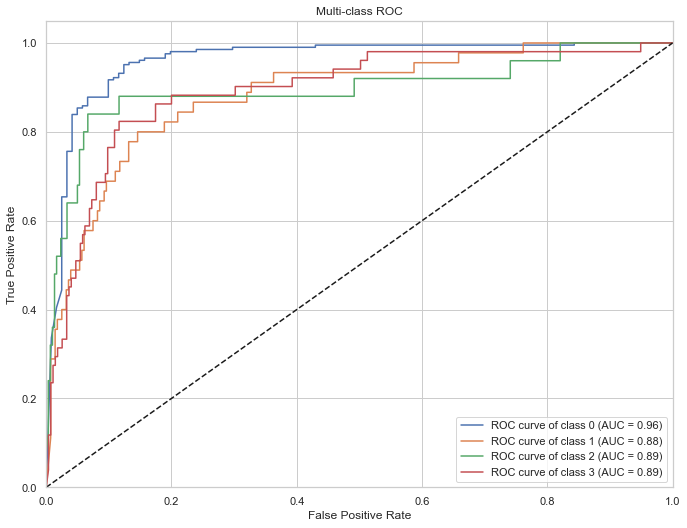

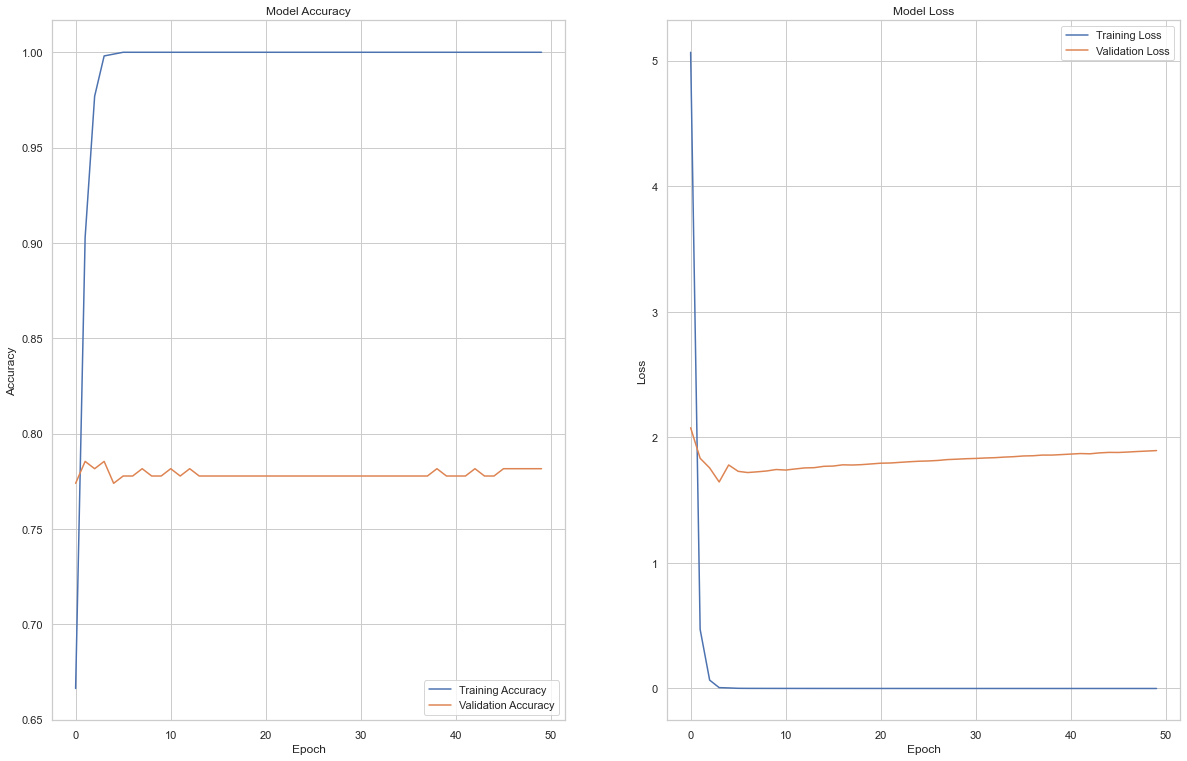

In [66]:
# 1. Model Evaluation
test_loss, test_accuracy = model.evaluate([X_lstm_test, X_cnn_test, X_combined_test], y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Get predictions
y_pred = model.predict([X_lstm_test, X_cnn_test, X_combined_test])
y_pred_classes = np.argmax(y_pred, axis=1)

# 2. Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(18, 12))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_test)))
plt.xticks(tick_marks, np.unique(y_test))
plt.yticks(tick_marks, np.unique(y_test))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 3. Classification Report
print(classification_report(y_test, y_pred_classes))

# 4. ROC Curve and AUC (for binary classification)
# If binary classification
if len(np.unique(y_test)) == 2:
    fpr, tpr, _ = roc_curve(y_test, y_pred[:, 1])
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
else:
    # For multi-class, you might want to use one-vs-rest ROC curves
    y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
    n_classes = y_test_bin.shape[1]
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {i} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC')
    plt.legend(loc="lower right")
    plt.show()

# 5. Learning Curves
plt.figure(figsize=(18, 12))
plt.subplot(121)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(122)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Alternative Approach

In [67]:
composers = ['Bach', 'Beethoven', 'Chopin', 'Mozart']

def midi_to_dataframe(midi_path):
    try:
        # Read the MIDI file
        midi = pm.PrettyMIDI(midi_path)
        data = []
        
        # Collect notes, control changes, and pitch bends
        for i, instrument in enumerate(midi.instruments):
            for note in instrument.notes:
                data.append([i, 'note', note.start, note.end, note.pitch, note.velocity])
            for control_change in instrument.control_changes:
                data.append([i, 'control_change', control_change.time, control_change.number, control_change.value])
            for pitch_bend in instrument.pitch_bends:
                data.append([i, 'pitch_bend', pitch_bend.time, pitch_bend.pitch])
        
        # Collect tempo changes from the first track only
        if i == 0:
            for tempo_change in midi.get_tempo_changes():
                data.append([0, 'tempo_change', tempo_change[0], tempo_change[1]])
        
        # Create a dataframe from the data
        df = pd.DataFrame(data, columns=['track', 'type', 'start', 'end', 'pitch_or_number', 'velocity_or_value'])
        return df
    except Exception as e:
        print(f"Error processing {midi_path}: {e}")
        return pd.DataFrame()

composer_dataframes = {}

for composer in composers:
    folder_path = os.path.join(root_dir, composer)
    if os.path.exists(folder_path):
        all_midi_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.mid')]
        composer_dfs = [midi_to_dataframe(midi_file) for midi_file in all_midi_files]
        # Filter out empty dataframes resulting from errors
        composer_dfs = [df for df in composer_dfs if not df.empty]
        if composer_dfs:
            composer_dataframes[composer] = pd.concat(composer_dfs, ignore_index=True)

# getting each composer's dataframe
bach_df = composer_dataframes.get('Bach', pd.DataFrame())
beethoven_df = composer_dataframes.get('Beethoven', pd.DataFrame())
chopin_df = composer_dataframes.get('Chopin', pd.DataFrame())
mozart_df = composer_dataframes.get('Mozart', pd.DataFrame())


Error processing ../aai-511_group1/midiclassics\Bach\017206vn.mid: index 1 is out of bounds for axis 0 with size 1
Error processing ../aai-511_group1/midiclassics\Beethoven\Anhang 14-3.mid: Could not decode key with 3 flats and mode 255
Error processing ../aai-511_group1/midiclassics\Beethoven\Op.51.mid: index 1 is out of bounds for axis 0 with size 1
Error processing ../aai-511_group1/midiclassics\Beethoven\Op33 No.4.mid: index 1 is out of bounds for axis 0 with size 1
Error processing ../aai-511_group1/midiclassics\Beethoven\Piano Sonata n10 2mov.mid: index 1 is out of bounds for axis 0 with size 1
Error processing ../aai-511_group1/midiclassics\Beethoven\Piano Sonata No.27.mid: index 1 is out of bounds for axis 0 with size 1
Error processing ../aai-511_group1/midiclassics\Beethoven\Piano Sonatina No.2 Op 49.mid: index 1 is out of bounds for axis 0 with size 1
Error processing ../aai-511_group1/midiclassics\Beethoven\Rage over a lost pennny.mid: index 1 is out of bounds for axis 0 wi

In [68]:
display(bach_df.info())
display(bach_df.describe())
display(bach_df.head())

display(beethoven_df.info())
display(beethoven_df.describe())
display(beethoven_df.head())

display(chopin_df.info())
display(chopin_df.describe())
display(chopin_df.head())

display(mozart_df.info())
display(mozart_df.describe())
display(mozart_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1616921 entries, 0 to 1616920
Data columns (total 6 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   track              1616921 non-null  int64  
 1   type               1616921 non-null  object 
 2   start              1616921 non-null  float64
 3   end                1616921 non-null  float64
 4   pitch_or_number    1616747 non-null  float64
 5   velocity_or_value  1585052 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 74.0+ MB


None

,track,start,end,pitch_or_number,velocity_or_value
count,1.616921e+06,1.616921e+06,1.616921e+06,1.616747e+06,1.585052e+06
mean,3.602469e+00,2.524180e+02,2.504737e+02,6.422670e+01,8.727483e+01
std,4.002943e+00,4.521988e+02,4.533015e+02,1.200881e+01,1.812877e+01
min,0.000000e+00,0.000000e+00,-4.820000e+02,0.000000e+00,1.000000e+00
25%,1.000000e+00,4.825170e+01,4.582750e+01,5.600000e+01,7.600000e+01
50%,2.000000e+00,1.331470e+02,1.302361e+02,6.600000e+01,9.200000e+01
75%,5.000000e+00,2.927466e+02,2.907925e+02,7.300000e+01,1.000000e+02
max,3.600000e+01,5.164605e+03,8.191000e+03,1.270000e+02,1.270000e+02


,track,type,start,end,pitch_or_number,velocity_or_value
0,0,note,1.956519,2.608692,69.0,96.0
1,0,note,2.608692,3.260865,69.0,96.0
2,0,note,3.260865,3.913038,69.0,96.0
3,0,note,3.913038,4.565211,69.0,96.0
4,0,note,4.565211,5.217384,71.0,96.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2255966 entries, 0 to 2255965
Data columns (total 6 columns):
 #   Column             Dtype  
---  ------             -----  
 0   track              int64  
 1   type               object 
 2   start              float64
 3   end                float64
 4   pitch_or_number    float64
 5   velocity_or_value  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 103.3+ MB


None

,track,start,end,pitch_or_number,velocity_or_value
count,2.255966e+06,2.255966e+06,2.255966e+06,2.255209e+06,1.584572e+06
mean,6.911058e+00,4.042209e+02,2.951620e+02,6.710967e+01,8.092177e+01
std,6.528223e+00,3.254852e+02,3.380193e+02,2.022751e+01,2.729829e+01
min,0.000000e+00,0.000000e+00,-4.000000e+02,0.000000e+00,1.000000e+00
25%,1.000000e+00,1.592316e+02,1.100000e+01,5.500000e+01,5.800000e+01
50%,5.000000e+00,3.268035e+02,1.861666e+02,6.600000e+01,8.100000e+01
75%,1.100000e+01,5.675869e+02,4.596945e+02,7.800000e+01,1.010000e+02
max,3.900000e+01,2.499968e+03,2.499368e+03,1.270000e+02,1.270000e+02


,track,type,start,end,pitch_or_number,velocity_or_value
0,0,note,2.205882,3.447289,72.0,66.0
1,0,note,3.433244,3.545604,75.0,66.0
2,0,note,3.601784,3.829725,74.0,66.0
3,0,note,4.307666,5.392002,67.0,66.0
4,0,note,5.392002,5.476272,67.0,64.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377294 entries, 0 to 377293
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   track              377294 non-null  int64  
 1   type               377294 non-null  object 
 2   start              377294 non-null  float64
 3   end                377294 non-null  float64
 4   pitch_or_number    377181 non-null  float64
 5   velocity_or_value  293537 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 17.3+ MB


None

,track,start,end,pitch_or_number,velocity_or_value
count,377294.000000,377294.000000,377294.000000,377181.000000,293537.000000
mean,1.773063,216.393669,169.412224,64.779695,68.495699
std,3.899438,232.631520,206.823691,23.801948,25.232057
min,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,55.909091,44.691952,54.000000,49.000000
50%,0.000000,135.018000,83.944121,64.000000,65.000000
75%,1.000000,296.129291,228.340661,75.000000,86.000000
max,19.000000,1352.454167,1352.741667,127.000000,127.000000


,track,type,start,end,pitch_or_number,velocity_or_value
0,0,note,0.000000,0.249908,70.0,105.0
1,0,note,0.000000,0.249908,63.0,105.0
2,0,note,0.312385,0.395687,70.0,105.0
3,0,note,0.312385,0.395687,63.0,105.0
4,0,note,0.416513,0.583118,70.0,105.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500582 entries, 0 to 1500581
Data columns (total 6 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   track              1500582 non-null  int64  
 1   type               1500582 non-null  object 
 2   start              1500582 non-null  float64
 3   end                1500582 non-null  float64
 4   pitch_or_number    1500146 non-null  float64
 5   velocity_or_value  1359925 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 68.7+ MB


None

,track,start,end,pitch_or_number,velocity_or_value
count,1.500582e+06,1.500582e+06,1.500582e+06,1.500146e+06,1.359925e+06
mean,3.952704e+00,2.750991e+02,2.528772e+02,6.627319e+01,8.027292e+01
std,3.715108e+00,2.386479e+02,2.337106e+02,1.908245e+01,2.327083e+01
min,0.000000e+00,0.000000e+00,-8.192000e+03,0.000000e+00,1.000000e+00
25%,1.000000e+00,9.934205e+01,7.073338e+01,5.700000e+01,6.200000e+01
50%,3.000000e+00,2.129252e+02,1.919483e+02,6.600000e+01,8.000000e+01
75%,6.000000e+00,3.773445e+02,3.585996e+02,7.600000e+01,1.000000e+02
max,1.900000e+01,1.478134e+03,4.095000e+03,1.270000e+02,1.270000e+02


,track,type,start,end,pitch_or_number,velocity_or_value
0,0,note,0.96,1.176,67.0,64.0
1,0,note,1.44,1.824,72.0,64.0
2,0,note,1.92,2.112,72.0,64.0
3,0,note,2.16,2.352,71.0,64.0
4,0,note,2.40,2.616,72.0,64.0


# References
1. https://machinelearningmastery.com/cnn-long-short-term-memory-networks/
2. https://colinraffel.com/publications/ismir2014intuitive.pdf
3. https://www.tensorflow.org/tutorials/audio/music_generation
4. https://craffel.github.io/pretty-midi/#
5. https://github.com/craffel/pretty-midi
6. https://www.cs.cmu.edu/~music/cmsip/readings/MIDI%20tutorial%20for%20programmers.html
7. https://cifkao.github.io/html-midi-player/ <-- MIDI Visualizer
8. https://signal.vercel.app/edit <-- MIDI Visualizer